# Pyomo - problem lociranja skladišta

Problem lociranja skladišta (engl. warehouse location problem) treba da optimizuje troškove koji prate uparivanje potrošača i njihovih snadbevača tj. skladišta. Neka je $N$ skup potencijalnih lokacija skladišta/snadbevača, a $M$ skup lokacija potrošača. Za svako skladište $n$ i svakog potrošača $m$ neka je cena isporuke zadata sa $d_{n, m}$. Potrebno je odrediti lokacije skladišta tako da se minimizuje cena isporuke za sve potrošače. Binarne promenljive $y_n$ će označavati da li skladište treba da se izgradi ili ne, a promenljive $x_{n, m}$ će označavati deo potreba potrošača $m$ koji dolazi iz skladišta $n$. Broj $P$ će označavati dozvoljeni broj skladišta.

Opisani problem se u matematičkim terminima može opisati na sledeći način: 

$$min \sum_{n \in N}\sum_{m \in M}{d_{n,m} x_{n, m}}$$ uz uslove 

$$\sum_{n \in N}{x_{n, m}} = 1\ za\ \forall {m\in M}$$

$$x_{n, m} \lt y_n\ za\ \forall {n\in N}\, \forall {m\in M}$$

$$\sum_{n \in N}{y_n}\lt P$$ 

$$0 \lt x \lt 1$$

$$y \in \{0, 1\}$$


In [1]:
from matplotlib import pyplot as plt

In [2]:
from pyomo.environ import *

In [3]:
%config Completer.use_jedi = False

U modelovanju ovog problema koristićemo sledeće podatke:

In [4]:
locations = ['Harlingen', 'Memphis', 'Ashland'] # N
customers = ['NYC', 'LA', 'Chicago', 'Houston'] # M

In [5]:
costs = {
    ('Harlingen', 'NYC'): 1956, \
    ('Harlingen', 'LA'): 1606, \
    ('Harlingen', 'Chicago'): 1410, \
    ('Harlingen', 'Houston'): 330, \
    ('Memphis', 'NYC'): 1096, \
    ('Memphis', 'LA'): 1792, \
    ('Memphis', 'Chicago'): 531, \
    ('Memphis', 'Houston'): 567, \
    ('Ashland', 'NYC'): 485, \
    ('Ashland', 'LA'): 2322, \
    ('Ashland', 'Chicago'): 324, \
    ('Ashland', 'Houston'): 1236 
}

Prvo ćemo konstruisati model pozivom funkcije `ConcreteModel`.

In [6]:
model = ConcreteModel()

In [7]:
model.locations = Set(initialize=locations)

In [8]:
model.customers = Set(initialize=customers)

Zatim ćemo uvesti niz binarnih promenljivih $y$ indeksiranih vrednostima iz niza $locations$.

In [9]:
model.y = Var(model.locations, within=Binary)

In [12]:
model.y['Harlingen']

Zatim ćemo uvesti i matricu promenljivih $x$ indeksiranih vrednostima iz nizova $locations$ i $customers$. Ovako uvedene promenljive će imati vrednosti u opsegu $[0, 1]$.

In [13]:
model.x = Var(model.locations, model.customers, bounds=(0,1))

Vrednostima ove matrice promenljivih možemo pristupati koristeći dvostruke indekse, na primer:

In [15]:
model.x['Harlingen', 'LA']

Broj dozvoljenih skladišta ćemo definisati kao skalarni parametar modela. Podrazumevano su parametri modela nepromenljivi i predstavljaju fiksirane vrednosti sa kojima model može da operiše. Ovde ćemo posebno, zbog eksperimentisanja sa različitim vrednostima broj skladišta, postaviti da je ovaj parametar promenljiv tako što ćemo iskoristiti argument `mutable`.

In [16]:
model.number_of_warehouses_limit = Param(initialize=2, mutable=True)

In [17]:
model.number_of_warehouses_limit.value

2

Pošto su forme ciljne funkcije i samih ograničenja kompleksnije, preći ćemo sa korišćenja parametra  `expr` na korišćenje parametra `rule` kojim se zadaju funkcije za izračunavanje izraza. 

In [18]:
for location in model.locations:
    print(location)

Harlingen
Memphis
Ashland


In [19]:
def objective_rule(model):
    return sum(costs[location, customer]*model.x[location, customer] for location in model.locations for customer in model.customers)

In [20]:
model.objective = Objective(rule=objective_rule)

Uslovom `customer_demand_rule` naglašavamo da potrošačeve potrebe moraju biti zadovoljene svim isporukama.

In [21]:
def customer_demand_rule(model, customer):
    return sum(model.x[location, customer] for location in model.locations) == 1

In [22]:
model.customer_demand = Constraint(model.customers, rule=customer_demand_rule)

Uslovom `warehouse_active_rule` naglašavamo validnost modela npr. ukoliko skladište na nekoj lokaciji nije aktivno, onda vrednosti isporuka sa tih lokacija, takođe, moraju biti nula. 

In [23]:
def warehouse_active_rule(model, location, customer):
    return model.x[location, customer] <= model.y[location]

In [24]:
model.warehouse_active = Constraint(model.locations, model.customers, rule=warehouse_active_rule)

Uslovom `number_of_warehouses_rule` naglašavamo da broj skladišta treba da bude manji od `number_of_warehouses_limit`.

In [25]:
def number_of_warehouses_rule(model):
    return sum(model.y[location] for location in model.locations) <= model.number_of_warehouses_limit

In [26]:
model.number_of_warehouses = Constraint(rule=number_of_warehouses_rule)

In [28]:
model.pprint()

4 Set Declarations
    customers : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'NYC', 'LA', 'Chicago', 'Houston'}
    locations : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'Harlingen', 'Memphis', 'Ashland'}
    warehouse_active_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : locations*customers :   12 : {('Harlingen', 'NYC'), ('Harlingen', 'LA'), ('Harlingen', 'Chicago'), ('Harlingen', 'Houston'), ('Memphis', 'NYC'), ('Memphis', 'LA'), ('Memphis', 'Chicago'), ('Memphis', 'Houston'), ('Ashland', 'NYC'), ('Ashland', 'LA'), ('Ashland', 'Chicago'), ('Ashland', 'Houston')}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : locations*customers :   12 : {('Harlingen', 'NYC'), ('H

Pošto smo kreirali model, iskoristićemo GLPK rešavača.

In [21]:
solver = SolverFactory('glpk')

In [22]:
result = solver.solve(model)

Lokacije skladišta možemo pročitati na osnovu vrednosti niza y.

In [23]:
model.y.pprint()

y : Size=3, Index=y_index
    Key       : Lower : Value : Upper : Fixed : Stale : Domain
      Ashland :     0 :   1.0 :     1 : False : False : Binary
    Harlingen :     0 :   1.0 :     1 : False : False : Binary
      Memphis :     0 :   0.0 :     1 : False : False : Binary


Opsluživanja klijenata možemo pročitati iz niza x.

In [24]:
model.x.pprint()

x : Size=12, Index=x_index
    Key                      : Lower : Value : Upper : Fixed : Stale : Domain
      ('Ashland', 'Chicago') :     0 :   1.0 :     1 : False : False :  Reals
      ('Ashland', 'Houston') :     0 :   0.0 :     1 : False : False :  Reals
           ('Ashland', 'LA') :     0 :   0.0 :     1 : False : False :  Reals
          ('Ashland', 'NYC') :     0 :   1.0 :     1 : False : False :  Reals
    ('Harlingen', 'Chicago') :     0 :   0.0 :     1 : False : False :  Reals
    ('Harlingen', 'Houston') :     0 :   1.0 :     1 : False : False :  Reals
         ('Harlingen', 'LA') :     0 :   1.0 :     1 : False : False :  Reals
        ('Harlingen', 'NYC') :     0 :   0.0 :     1 : False : False :  Reals
      ('Memphis', 'Chicago') :     0 :   0.0 :     1 : False : False :  Reals
      ('Memphis', 'Houston') :     0 :   0.0 :     1 : False : False :  Reals
           ('Memphis', 'LA') :     0 :   0.0 :     1 : False : False :  Reals
          ('Memphis', 'NYC') :     0 

Vrednost ciljne funkcije predstavlja vrednost troškova transporta.

In [25]:
model.objective()

2745.0

Sada možemo proveriti kako se ponaša ciljna funkcija za nešto drugačije vrednosti broj dozvoljenih skladišta.

In [26]:
objectives = []
for limit in range(1, len(locations)+1):
    model.number_of_warehouses_limit = limit
    result = solver.solve(model)
    if result.solver.status == 'ok':
        objectives.append(model.objective())

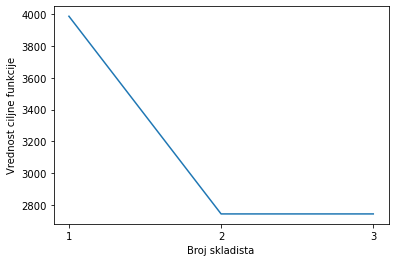

In [27]:
plt.plot(range(1, len(locations)+1), objectives)
plt.xlabel('Broj skladista')
plt.xticks(range(1, len(locations)+1), range(1, len(locations)+1))
plt.ylabel('Vrednost ciljne funkcije')
plt.show()

Primetimo da je za dva skladišta vrednost funkcije minimalna. 